### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import sklearn
import torch
import torchvision.transforms as transforms

### Load the dataset into dataframe

In [2]:
# Load the metadata (labels)
metadata_path = "../HAM10000/GroundTruth.csv"
metadata = pd.read_csv(metadata_path)
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
print("Metadata Shape:", metadata.shape)
metadata["label"] = metadata[classes].idxmax(axis=1)
print("\nFirst few rows of metadata:")
print(metadata.head())

Metadata Shape: (10015, 8)

First few rows of metadata:
          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0    NV
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0   MEL


In [3]:
class_counts = metadata[classes].sum()
print("\nClass Distribution:")
print(class_counts)


Class Distribution:
MEL      1113.0
NV       6705.0
BCC       514.0
AKIEC     327.0
BKL      1099.0
DF        115.0
VASC      142.0
dtype: float64


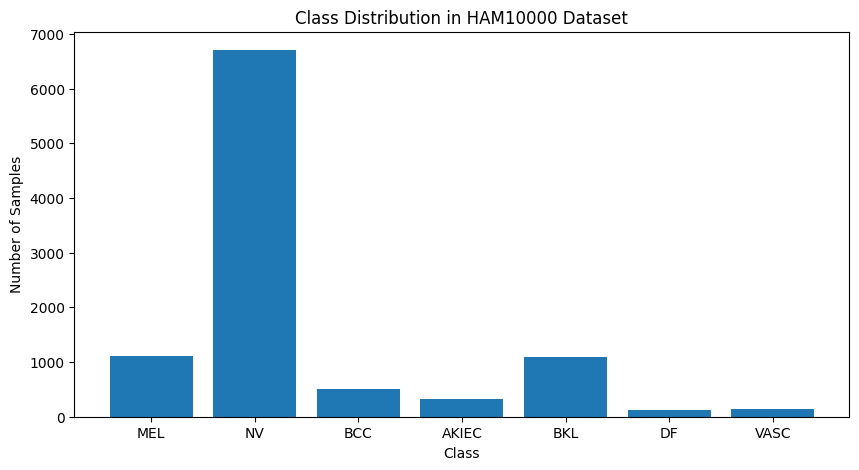

In [4]:
# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values)
plt.title("Class Distribution in HAM10000 Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

### Sample to make sure everything is fine

In [5]:
# Load and display a sample image, mask, and label
sample = metadata.iloc[25]  # First row
image_id = sample["image"]
label = classes[sample[classes].values.argmax()]  # Get the class with value 1

# Load image and mask
image_path = f"../HAM10000/images/{image_id}.jpg"
mask_path = f"../HAM10000/masks/{image_id}_segmentation.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image (Label: {label})")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


### TRAIN / TEST / VALIDATION SPLIT

In [5]:
# Split into train and test+val (70% train, 30% test+val)
from sklearn.model_selection import train_test_split


train_data, test_val_data = train_test_split(
    metadata,
    test_size=0.3,
    random_state=42,
    stratify=metadata["label"]
)

# Split test+val into test and val (15% test, 15% val)
test_data, val_data = train_test_split(
    test_val_data,
    test_size=0.5,  # 0.5 of 30% = 15% of total
    random_state=42,
    stratify=test_val_data["label"]
)

# Print the sizes of each split
print("\nDataset Split Sizes:")
print(f"Training set: {len(train_data)} samples ({len(train_data)/len(metadata)*100:.1f}%)")
print(f"Validation set: {len(val_data)} samples ({len(val_data)/len(metadata)*100:.1f}%)")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(metadata)*100:.1f}%)")

# Check class distribution in each split
print("\nClass Distribution in Training Set:")
print(train_data["label"].value_counts())
print("\nClass Distribution in Validation Set:")
print(val_data["label"].value_counts())
print("\nClass Distribution in Test Set:")
print(test_data["label"].value_counts())


Dataset Split Sizes:
Training set: 7010 samples (70.0%)
Validation set: 1503 samples (15.0%)
Test set: 1502 samples (15.0%)

Class Distribution in Training Set:
label
NV       4693
MEL       779
BKL       769
BCC       360
AKIEC     229
VASC       99
DF         81
Name: count, dtype: int64

Class Distribution in Validation Set:
label
NV       1006
MEL       167
BKL       165
BCC        77
AKIEC      49
VASC       22
DF         17
Name: count, dtype: int64

Class Distribution in Test Set:
label
NV       1006
MEL       167
BKL       165
BCC        77
AKIEC      49
VASC       21
DF         17
Name: count, dtype: int64


### Create empty folder

In [ ]:
import os
import shutil

# Define the classes
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Define the base paths
base_image_path = "../HAM10000/images/"
base_mask_path = "../HAM10000/masks/"

# Define the splits
splits = ["train", "val", "test"]

# Create the new folder structure
for split in splits:
    for class_name in classes:
        # Create image folders (e.g., images/train/MEL/)
        image_split_class_path = os.path.join(base_image_path, split, class_name)
        os.makedirs(image_split_class_path, exist_ok=True)
        
        # Create mask folders (e.g., masks/train/MEL/)
        mask_split_class_path = os.path.join(base_mask_path, split, class_name)
        os.makedirs(mask_split_class_path, exist_ok=True)

print("Folder structure created successfully.")

Folder structure created successfully.


### SPLIT DATA INTO SPECIFIC FOLDERS

In [ ]:
# Function to move files for a given split
def move_files(data, split_name):
    for _, row in data.iterrows():
        image_id = row["image"]
        label = row["label"]
        
        # Source paths
        src_image_path = f"../HAM10000/images/{image_id}.jpg"
        src_mask_path = f"../HAM10000/masks/{image_id}_segmentation.png"
        
        # Destination paths
        dst_image_path = f"../HAM10000/images/{split_name}/{label}/{image_id}.jpg"
        dst_mask_path = f"../HAM10000/masks/{split_name}/{label}/{image_id}_segmentation.png"
        
        # Move files (copy then delete to be safe)
        if os.path.exists(src_image_path) and os.path.exists(src_mask_path):
            shutil.copy2(src_image_path, dst_image_path)
            shutil.copy2(src_mask_path, dst_mask_path)
            os.remove(src_image_path)  # Remove the original file
            os.remove(src_mask_path)
        else:
            print(f"Missing file for {image_id} in {split_name} split")

# Move files for each split
move_files(train_data, "train")
move_files(val_data, "val")
move_files(test_data, "test")

print("Files moved successfully.")

Files moved successfully.


### Data Precoessing

In [6]:
import cv2
import os

# Define the splits and classes
splits = ["train", "val", "test"]
classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Base paths
base_image_path = "../HAM10000/images/"
base_mask_path = "../HAM10000/masks/"

# Check for corrupt files and remove them
for split in splits:
    for class_name in classes:
        image_dir = os.path.join(base_image_path, split, class_name)
        mask_dir = os.path.join(base_mask_path, split, class_name)
        
        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)
        
        print(f"\nChecking {split}/{class_name}...")
        print(f"Initial: {len(image_files)} images, {len(mask_files)} masks")
        
        # Check each image
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            mask_file = image_file.replace(".jpg", "_segmentation.png")
            mask_path = os.path.join(mask_dir, mask_file)
            
            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Check if either file is corrupt or missing
            if image is None or mask is None or mask_file not in mask_files:
                print(f"Corrupt or missing pair: {image_file} in {split}/{class_name}")
                if os.path.exists(image_path):
                    os.remove(image_path)
                if os.path.exists(mask_path):
                    os.remove(mask_path)
        
        # Recount after removal
        image_files = os.listdir(image_dir)
        mask_files = os.listdir(mask_dir)
        print(f"After cleanup: {len(image_files)} images, {len(mask_files)} masks")
        
        # Final check for mismatch
        if len(image_files) != len(mask_files):
            print(f"Warning: Mismatch in {split}/{class_name} after cleanup")


Checking train/MEL...
Initial: 779 images, 779 masks
After cleanup: 779 images, 779 masks

Checking train/NV...
Initial: 4693 images, 4693 masks
After cleanup: 4693 images, 4693 masks

Checking train/BCC...
Initial: 360 images, 360 masks
After cleanup: 360 images, 360 masks

Checking train/AKIEC...
Initial: 229 images, 229 masks
After cleanup: 229 images, 229 masks

Checking train/BKL...
Initial: 769 images, 769 masks
After cleanup: 769 images, 769 masks

Checking train/DF...
Initial: 81 images, 81 masks
After cleanup: 81 images, 81 masks

Checking train/VASC...
Initial: 99 images, 99 masks
After cleanup: 99 images, 99 masks

Checking val/MEL...
Initial: 167 images, 167 masks
After cleanup: 167 images, 167 masks

Checking val/NV...
Initial: 1006 images, 1006 masks
After cleanup: 1006 images, 1006 masks

Checking val/BCC...
Initial: 77 images, 77 masks
After cleanup: 77 images, 77 masks

Checking val/AKIEC...
Initial: 49 images, 49 masks
After cleanup: 49 images, 49 masks

Checking val

In [7]:
import torchvision.transforms as transforms

# Define image size (e.g., 224x224, common for CNNs like ResNet)
IMG_SIZE = (224, 224)

# Define transformations for images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),  # Data augmentation for training
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for masks (resize only, no normalization)
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [8]:
from torch.utils.data import Dataset
import cv2
import os

class SkinCancerDataset(Dataset):
    def __init__(self, split, transform=None, mask_transform=None):
        self.split = split  # 'train', 'val', or 'test'
        self.transform = transform
        self.mask_transform = mask_transform
        self.classes = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            image_dir = f"../HAM10000/images/{split}/{class_name}/"
            for image_file in os.listdir(image_dir):
                self.image_paths.append(os.path.join(image_dir, image_file))
                self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Load mask
        mask_path = image_path.replace("images", "masks").replace(".jpg", "_segmentation.png")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0).float()  # Ensure mask is binary (0 or 1)
        
        label = self.labels[idx]
        return image, mask, label

# Create datasets
train_dataset = SkinCancerDataset("train", transform=train_transforms, mask_transform=mask_transforms)
val_dataset = SkinCancerDataset("val", transform=val_test_transforms, mask_transform=mask_transforms)
test_dataset = SkinCancerDataset("test", transform=val_test_transforms, mask_transform=mask_transforms)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7010
Validation dataset size: 1503
Test dataset size: 1502


In [9]:
from torch.utils.data import DataLoader
import time

# Define batch size
BATCH_SIZE = 32

# Create DataLoaders with num_workers=0 to avoid multiprocessing issues
start_time = time.time()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print(f"Train loader creation took {time.time() - start_time:.2f} seconds")

start_time = time.time()
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Val loader creation took {time.time() - start_time:.2f} seconds")

start_time = time.time()
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(f"Test loader creation took {time.time() - start_time:.2f} seconds")

# Verify a batch
start_time = time.time()
images, masks, labels = next(iter(train_loader))
print(f"Loading first batch took {time.time() - start_time:.2f} seconds")
print(f"Batch shapes - Images: {images.shape}, Masks: {masks.shape}, Labels: {labels.shape}")

Train loader creation took 0.00 seconds
Val loader creation took 0.00 seconds
Test loader creation took 0.00 seconds
Loading first batch took 0.34 seconds
Batch shapes - Images: torch.Size([32, 3, 224, 224]), Masks: torch.Size([32, 1, 224, 224]), Labels: torch.Size([32])


In [10]:
print(images.shape)

torch.Size([32, 3, 224, 224])


# Classification Model 

In [11]:
import torch
import torch.nn as nn

class SkinCancerCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCancerCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Output: 32 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32 x 112 x 112

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: 64 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64 x 56 x 56

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# Output: 128 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 128 x 28 x 28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    
    def forward(self, x):
        x = self.features(x)  # Do the pattern-finding steps
        x = self.classifier(x)  # Make the final guess
        return x

# Create the model and check if we can use a GPU (faster) or CPU (slower)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SkinCancerCNN(num_classes=7).to(device)
# Example: Move input data to GPU before passing it to the model
input_tensor = torch.randn(1, 3, 224, 224).to(device)
output = model(input_tensor)  # Now runs on GPU


print("CUDA Available:", torch.cuda.is_available())
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

# Count how many "settings" the model has
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

CUDA Available: False
GPU Count: 0
GPU Name: No GPU detected
Total parameters: 6,447,143


In [12]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get the labels from the training data
train_labels = []
for _, _, label in train_dataset:  # We only need the labels, not the images or masks
    train_labels.append(label)

# Calculate weights for each class (to balance the dataset)
class_weights = compute_class_weight(
    class_weight='balanced',  # This makes sure rare classes get more importance
    classes=np.arange(7),     # The 7 classes (0=MEL, 1=NV, 2=BCC, 3=AKIEC, 4=BKL, 5=DF, 6=VASC)
    y=train_labels            # The labels from the training data
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([ 1.2855,  0.2134,  2.7817,  4.3731,  1.3022, 12.3633, 10.1154])


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a random tensor and move it to GPU
tensor = torch.randn(1, 3, 224, 224).to(device)
print(tensor.device)  # Should print "cuda:0"

# Move model to GPU
model.to(device)

# Generate a random input and ensure model runs on GPU
input_tensor = torch.randn(1, 3, 224, 224).to(device)
output = model(input_tensor)
print(output.device)  # Should print "cuda:0"


cpu
cpu


In [14]:
import torch.optim as optim

# Set up the "scoring system" and "learning method"
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Scoring system that uses the weights

# Method to help the model learn with L2 regularization (weight_decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Adding L2 regularization (weight_decay)

# Teach the model for 10 rounds
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Tell the model we're in "learning mode"
    total_loss = 0.0  # Keep track of how many mistakes the model makes
    
    # Show the model each batch of training images
    for images, _, labels in train_loader:  # We don't need the masks for classification
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
        
        optimizer.zero_grad()  # Reset the learning process
        guesses = model(images)  # Let the model guess the cancer type
        loss = criterion(guesses, labels)  # Check how wrong the guesses are
        loss.backward()  # Tell the model what it got wrong
        optimizer.step()  # Help the model learn from its mistakes
        
        total_loss += loss.item()  # Add up the mistakes
    
    # Check how well the model is doing on the validation images
    model.eval()  # Tell the model we're in "testing mode"
    val_loss = 0.0  # Track mistakes on validation data
    correct = 0  # Count correct guesses
    total = 0  # Count total guesses
    with torch.no_grad():  # Don't learn, just test
        for images, _, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            guesses = model(images)
            loss = criterion(guesses, labels)
            val_loss += loss.item()
            
            # Count how many guesses were correct
            best_guess = guesses.argmax(dim=1)  # Pick the highest score as the guess
            total += labels.size(0)  # Add up the number of images
            correct += (best_guess == labels).sum().item()  # Count correct guesses
    
    # Print how the model did in this round
    print(f"Round {epoch+1}/{num_epochs}, Training Mistakes: {total_loss/len(train_loader):.4f}, "
          f"Validation Mistakes: {val_loss/len(val_loader):.4f}, Validation Correct: {100 * correct / total:.2f}%")


Round 1/10, Training Mistakes: 1.8179, Validation Mistakes: 1.1623, Validation Correct: 63.41%
Round 2/10, Training Mistakes: 1.6686, Validation Mistakes: 1.4971, Validation Correct: 38.52%
Round 3/10, Training Mistakes: 1.6113, Validation Mistakes: 1.1502, Validation Correct: 59.81%
Round 4/10, Training Mistakes: 1.5025, Validation Mistakes: 1.1704, Validation Correct: 54.49%
Round 5/10, Training Mistakes: 1.4616, Validation Mistakes: 1.3167, Validation Correct: 48.90%
Round 6/10, Training Mistakes: 1.4031, Validation Mistakes: 1.2076, Validation Correct: 49.90%


KeyboardInterrupt: 